## Multiple examples doing predictions and comparing with baseline

(This is intended to be a testing code, so it has some relaxed coding practises)

IMPORTANT  
To run this code you need to download all the model's checkpoints.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re
import context
from mlnowcasting.models.architectures.example_model import get_model
from mlnowcasting.models.params.example_params import params
from mlnowcasting.models.losses.example_loss import get_loss_fx
from mlnowcasting.utils.torch_trainer import Torch_Trainer
from mlnowcasting.utils.metrics import events_metrics, metric_plots
from mlnowcasting.utils.utils import any2reflectivity
from mlnowcasting.utils.plot_utils import plot_obs_pred, plot_pred
from mlnowcasting.composite import composite_prediction
from mlnowcasting.predict import predict

from mlnowcasting.baseline.pysteps_nowcast import pysteps_nowcast
from mlnowcasting.baseline.rainnet import rainnet
from mlnowcasting.baseline.rainnet import HiddenPrints

/s/chopin/d/proj/jcuomo/699/repository
Pysteps configuration file found at: /s/chopin/a/grad/jcuomo/.local/lib/python3.7/site-packages/pysteps/pystepsrc



Define the dataset, which has to contain both context+observation, so the metrics can be computed.

events_names is optional, and is a npy file with every frame title (RADAR+TIME)

In [2]:
global dataset
global test
global test_names

dataset      = '../data/datasets/example_dataset.npy'
events_names = '../data/datasets/example_names.npy'

In [3]:
device = torch.device("cuda:0")
test = np.load(dataset)
test_names = np.load(events_names, allow_pickle=True)

In case you need to modify the names appearing in the plots, change this fx.

In [4]:
def getName(name):
    return name

## Single-model analysis

Define fx for the third-party models: pysteps, darts, rainnet.

In [5]:
def fill_nans(y):
    where_are_NaNs = np.isnan(y)
    y[where_are_NaNs] = 0
    return y

def others_models_metrics(model_names, th_dbz, fig):
    
    fi=fo=16
    context = test[:,:fi]
    target  = test[:,fi:fi+fo]
    for model_name in model_names:
        if 'DARTS' in model_name:
            prediction = np.load(model_name)
            model_name = 'DARTS'
        if model_name == 'RainNet':
            prediction = rainnet(context)
        else:
            prediction = pysteps_nowcast(model_name).predict(context, target, th_dbz, n_leadtimes=fo)
            #predict = fill_nans(predict)
        metric_stat, fig = metric_plots(target, prediction, time_res=5, th_dbz=th_dbz, std_lines=0, fig=fig, model=model_name)

    return fig

def plot_others_models(model_names, th_dbz, N=0, plot_OBS=False, plot_map=False):
    
    fi=fo=16
    context = test[N:N+1,:fi]
    target  = test[N:N+1,fi:fi+fo]
    t = target/255*70
    if plot_OBS:
        plot_OBS=False
        plot_pred(t[0], plot_map=plot_map, title_files=test_names[N])
    for i,model_name in enumerate(model_names):
        bottom_label = (i==len(model_names)-1) #True in the last iter
        
        if 'DARTS' in model_name:
            prediction = np.load(model_name)[N:N+1]
            model_name = 'DARTS'
        if model_name == 'rainnet':
            prediction = rainnet(context)/255*70
        else:
            prediction = pysteps_nowcast(model_name).predict(context, target, th_dbz, n_leadtimes=fo)/255*70
            prediction = fill_nans(prediction)
            
        plot_pred(prediction[0], plot_map=plot_map, label=model_name, title_files=test_names[N], plot_colorbar=0, bottom_label=bottom_label)

### PySteps example

Samples used: 10
Samples used: 10
Samples used: 10
Samples used: 10


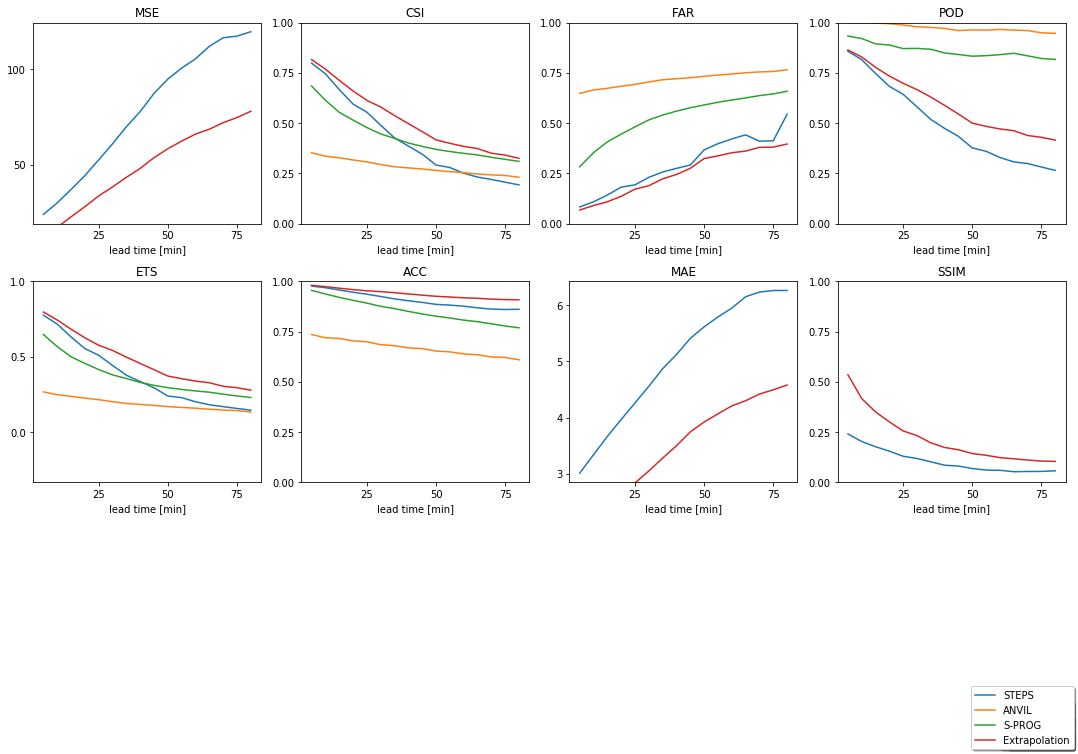

In [6]:
pysteps = ['STEPS',
           'ANVIL', 
           'S-PROG', 
           'Extrapolation']

th = 20 # metric threshold in dBZ
N = 0 # sample to plot
fig = others_models_metrics(pysteps, th, None)
fig

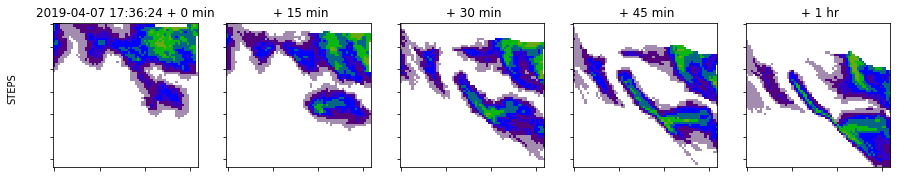

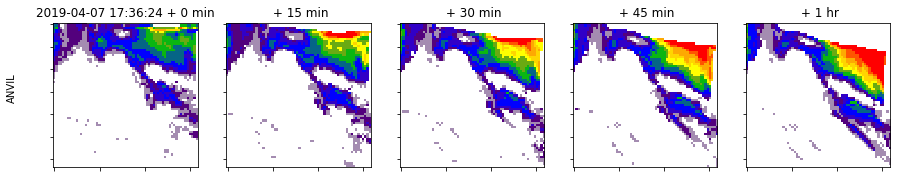

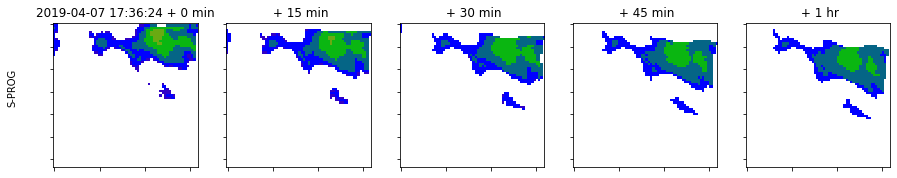

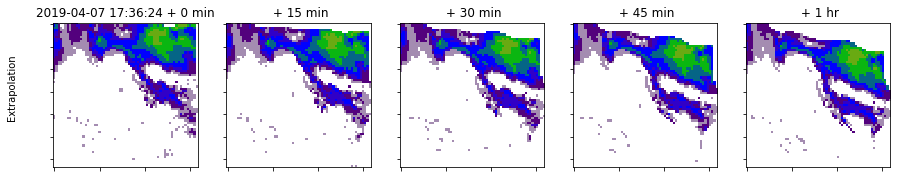

In [7]:
plot_others_models(pysteps, th, N, plot_OBS=False, plot_map=False)

### RainNet example

I wasn't able to free CUDA memory after using tensorflow, so you would probably have to restart the kernel after running RainNet to keep going with the rest of the example.

Using TensorFlow backend.


Samples used: 10


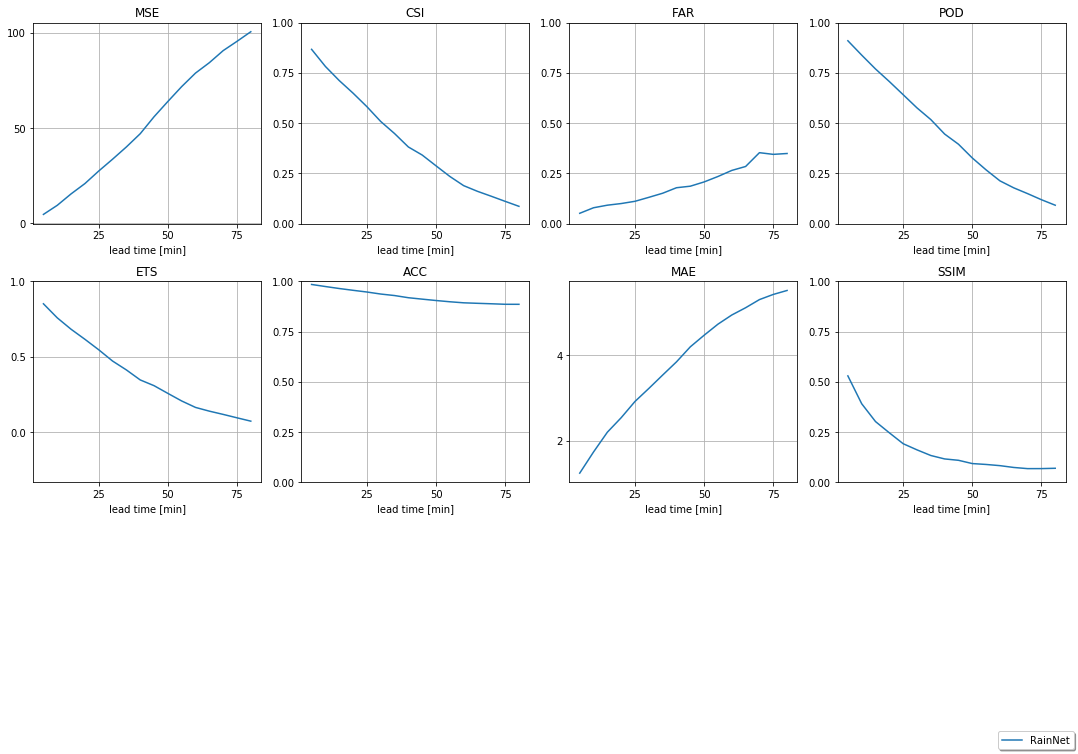

In [8]:
file_rainnet = ['RainNet']
th = 20 # metric threshold in dBZ
fig = others_models_metrics(file_rainnet, 20, None)
fig

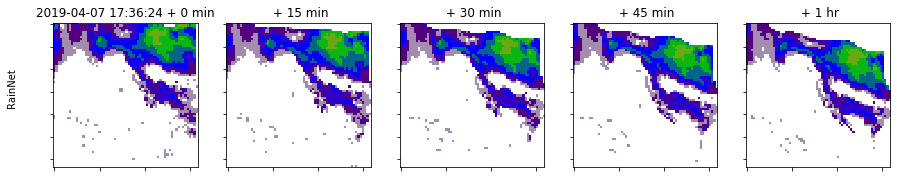

In [9]:
N = 0 # sample to plot
plot_others_models(file_rainnet, th, N, plot_OBS=False, plot_map=False)

### DARTS example

This model is used externally, and the only way to compare the metrics is to have the predictions in a npy file correspoding to the context from the dataset.

Samples used: 10


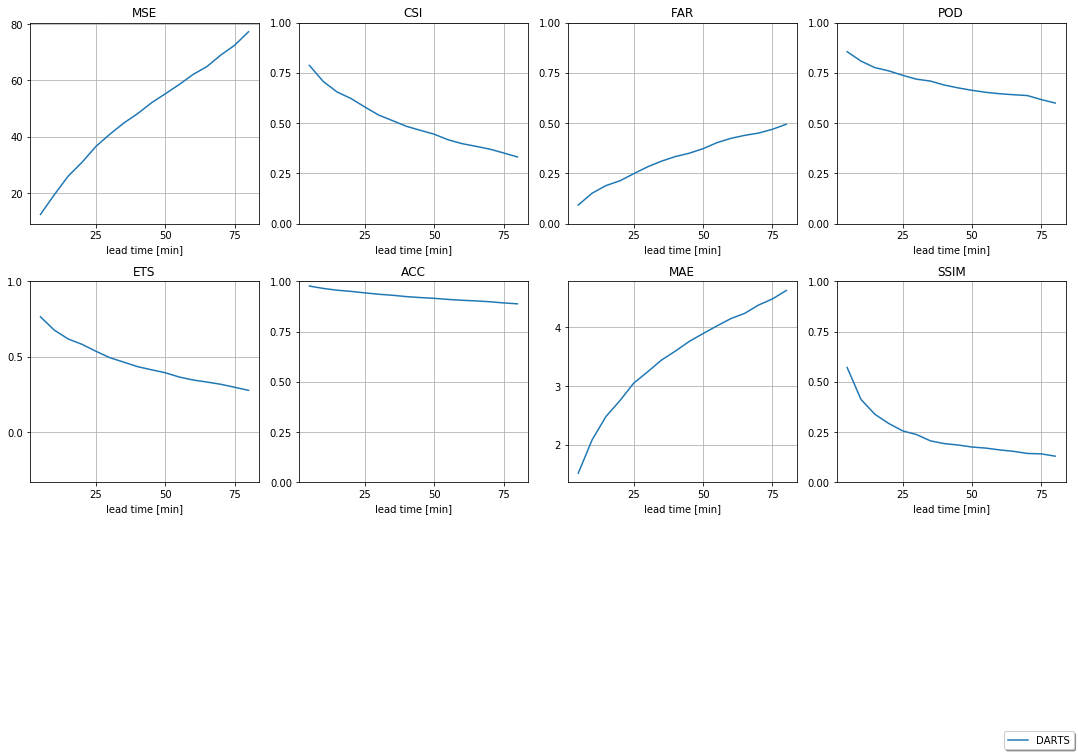

In [10]:
file_darts = ['../data/checkpoints/DARTS_denver.npy']
th = 20 # metric threshold in dBZ
fig = others_models_metrics(file_darts, th, None)
fig

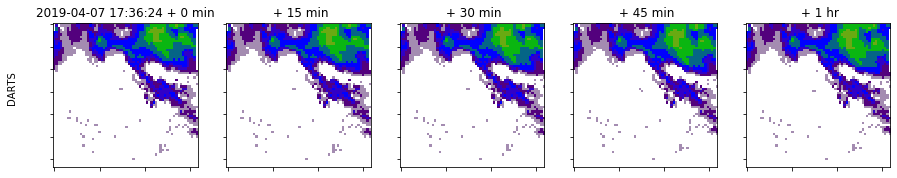

In [11]:
N = 0 # sample to plot
plot_others_models(file_darts, None, N, plot_OBS=False, plot_map=False)

Define fx for the models: resConv, sequential, resGRU, trajGRU.

In [6]:
def my_models_metrics(files, th_dbz, fig):
    with torch.no_grad():
        for file in files:
            prediction, target = predict(dataset, file)
            model_name = getName(file)
            metric_stat, fig = metric_plots(target, prediction, time_res=5, th_dbz=th_dbz, std_lines=0, fig=fig, model=model_name)
    return fig

def plot_my_models(files, th_dbz, N=0, plot_OBS=False, plot_map=False):
    with torch.no_grad():
        for i, file in enumerate(files):
            bottom_label = (i==len(files)-1) #True in the last iter
            prediction, target = predict(dataset, file, N=N)
           
            if th_dbz is not None:
                prediction = binarize(prediction,th_dbz)
                prediction = binarize(target,th_dbz)
            model_name = getName(file)
            if plot_OBS:
                plot_OBS=False
                plot_pred(target[0], plot_map=plot_map, title_files=test_names[N], N_frames=5)
            plot_pred(prediction[0], plot_map=plot_map, N_frames=5, label=model_name, title_files=test_names[N], plot_colorbar=0, bottom_label=bottom_label)

### resConv example

=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)
Samples used: 10


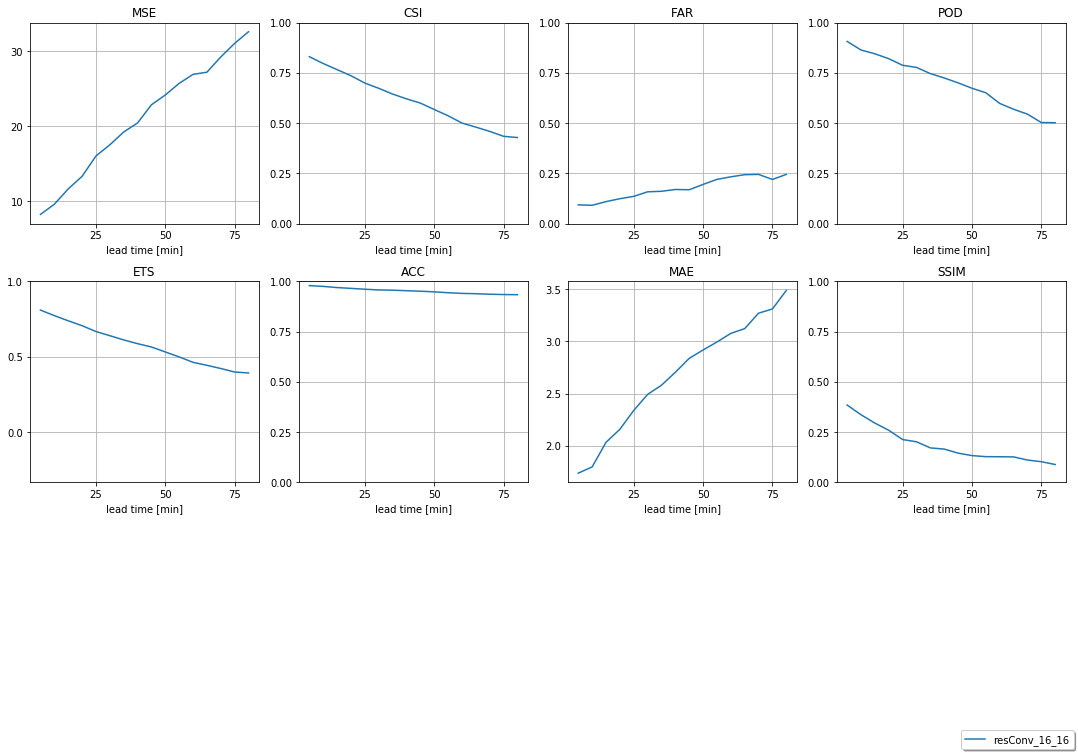

In [7]:
files = ['resConv_16_16']
th = 20 # metric threshold in dBZ
fig = my_models_metrics(files, th, None)
fig

=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)


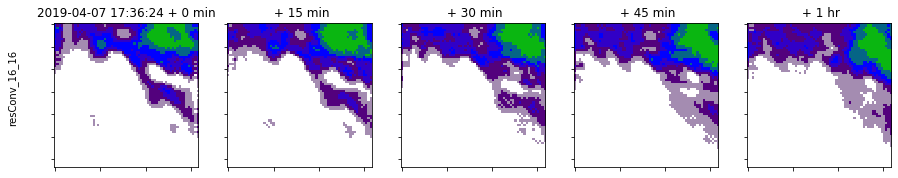

In [8]:
N = 0 # sample to plot
plot_my_models(files, None, N=N, plot_OBS=0, plot_map=0)

Define fx for the binary models: e.g. resConv_bin20

In [9]:
%load_ext autoreload
%autoreload 2
def my_binary_metrics(files, th_dbz, fig):
    with torch.no_grad():
        for file in files:
            prediction, target = predict(dataset, file)
            prediction = np.where(prediction > 0.5, 1,0)
            model_name = getName(file)
            metric_stat, fig = metric_plots(target, prediction, time_res=5, th_dbz=th_dbz, std_lines=1, fig=fig, model=model_name)
    return fig

def plot_my_binary(files, th_dbz, N=0, plot_OBS=False, plot_map=False):
    with torch.no_grad():
        for i, file in enumerate(files):
            bottom_label = (i==len(files)-1) #True in the last iter
            prediction, target = predict(dataset, file, N=N)
           
            prediction = np.where(prediction > 0.5, 1, 0) 
            target     = np.where(target > th_dbz/70, 1, 0)

            model_name = getName(file)
            if plot_OBS:
                plot_OBS=False
                plot_pred(target[0], plot_map=plot_map, title_files=test_names[N])
            plot_pred(prediction[0], plot_map=plot_map, label=model_name, title_files=test_names[N], plot_colorbar=0, bottom_label=bottom_label)


### Binary example

=> loaded checkpoint 'resConv_16_16_bin20.pth' (trained for 24 epochs)
Samples used: 10


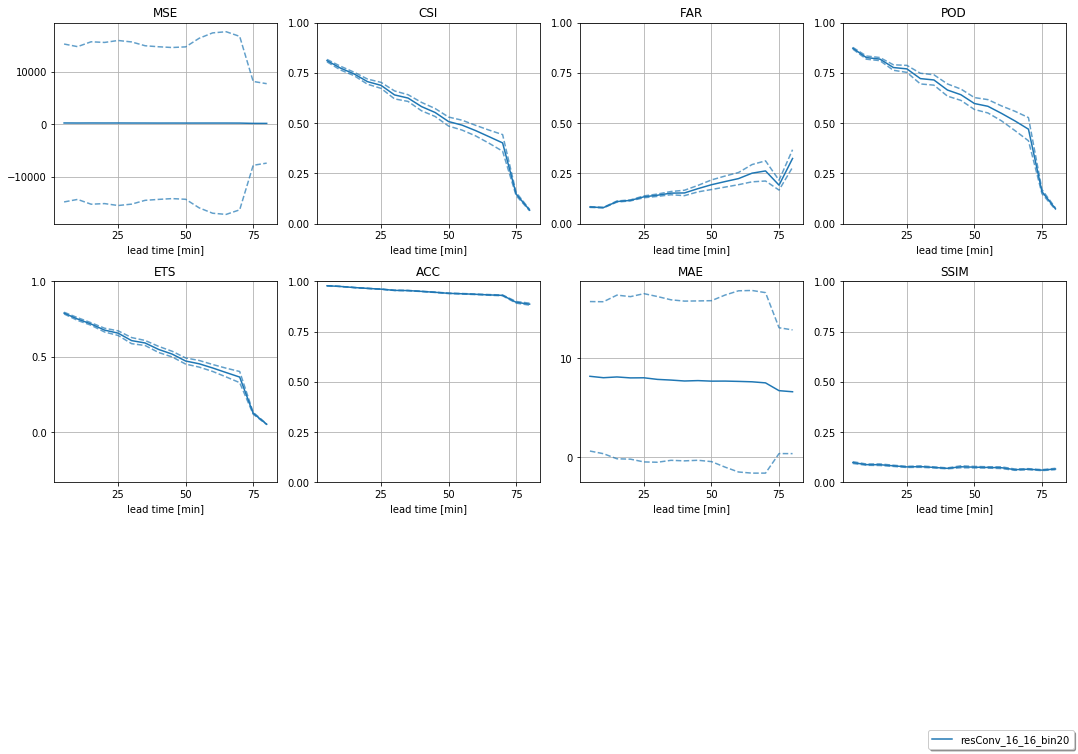

In [10]:
binary_files = ['resConv_16_16_bin20']
th = 20 # metric threshold in dBZ
fig = my_binary_metrics(binary_files, th, None)
fig

=> loaded checkpoint 'resConv_16_16_bin20.pth' (trained for 24 epochs)


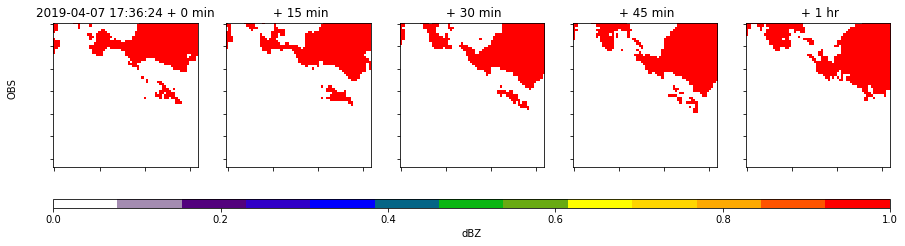

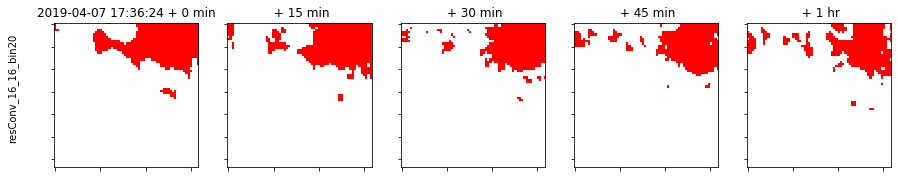

In [11]:
N = 0 # sample to plot
plot_my_binary(binary_files, th, N=N, plot_OBS=1, plot_map=0)

Define fx for the composite model

In [20]:
def my_composite_metrics(file, th_dbz, fig=None):
    prediction, target, layers = composite_prediction(dataset, file)
    model_name = 'Composite'
    metric_stat, fig = metric_plots(target, prediction, time_res=5, th_dbz=th_dbz, std_lines=0, fig=fig, model=model_name)
    return fig

def plot_my_composite(file, th_dbz, N=0, plot_layers=False, plot_OBS=False, plot_map=False):

    prediction, target, layers = composite_prediction(dataset, file, N)
    model_name = 'Composite'
    if plot_OBS:
        plot_OBS=False
        plot_pred(target[0], plot_map=plot_map, title_files=test_names[N])
    plot_pred(prediction[0], plot_map=plot_map, label=model_name, title_files=test_names[N])
    if plot_layers:
        i = 0
        for layer in layers:
            ths = [0,20,25,30,35,40,45,50]
            if ths[i] != 0:
                layer = np.where(layer*70>35,ths[i],0)
                plot_pred(layer[0], plot_map=plot_map, label=str(ths[i])+' dBZ', title_files=test_names[N])
            else:
                plot_pred(layer[0], plot_map=plot_map, label='base', title_files=test_names[N])
                
            i += 1    

### Composite example

=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)
=> loaded checkpoint 'resConv_16_16_bin20.pth' (trained for 24 epochs)
=> loaded checkpoint 'resConv_16_16_bin25.pth' (trained for 23 epochs)
=> loaded checkpoint 'resConv_16_16_bin30.pth' (trained for 11 epochs)
=> loaded checkpoint 'resConv_16_16_bin35.pth' (trained for 16 epochs)
Samples used: 10


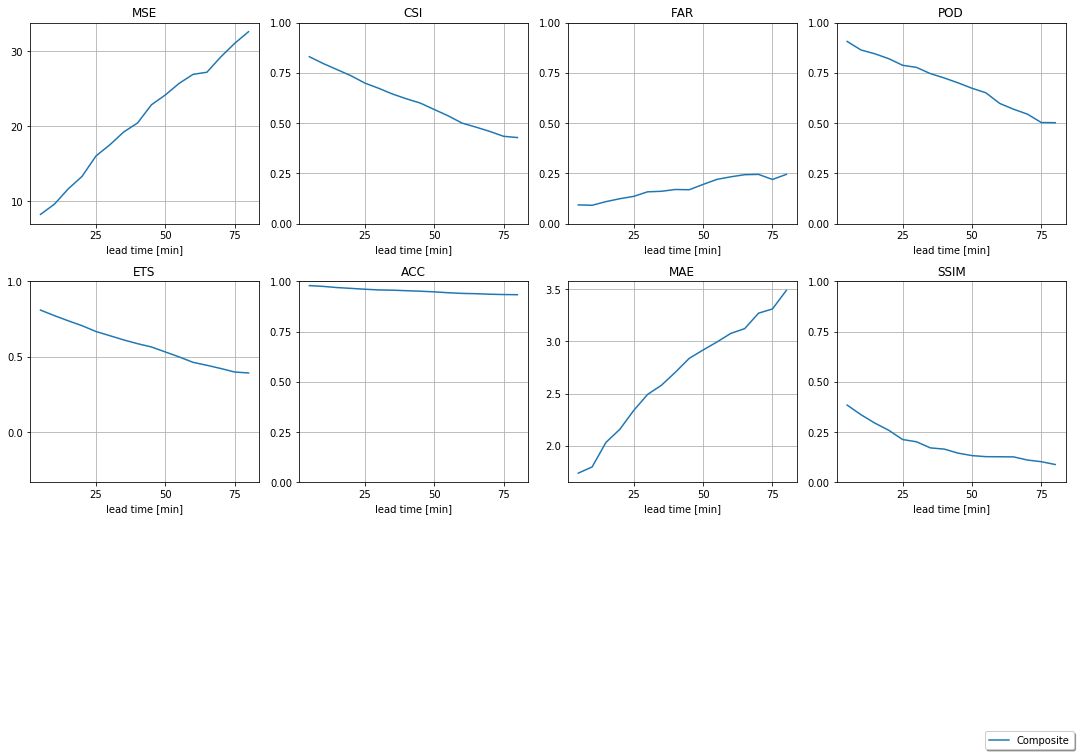

In [13]:
composite_base_file = 'resConv_16_16'
th = 20 # metric threshold in dBZ
fig = my_composite_metrics(composite_base_file, th, None)
fig

=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)
=> loaded checkpoint 'resConv_16_16_bin20.pth' (trained for 24 epochs)
=> loaded checkpoint 'resConv_16_16_bin25.pth' (trained for 23 epochs)
=> loaded checkpoint 'resConv_16_16_bin30.pth' (trained for 11 epochs)
=> loaded checkpoint 'resConv_16_16_bin35.pth' (trained for 16 epochs)


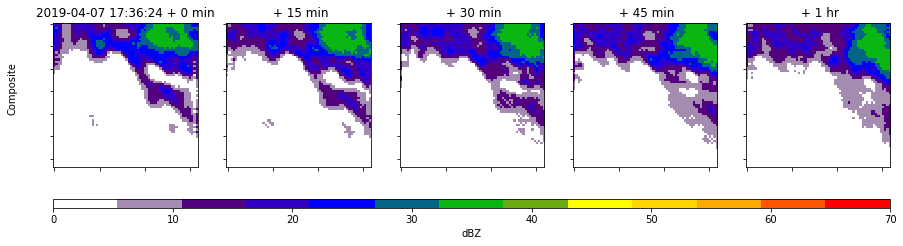

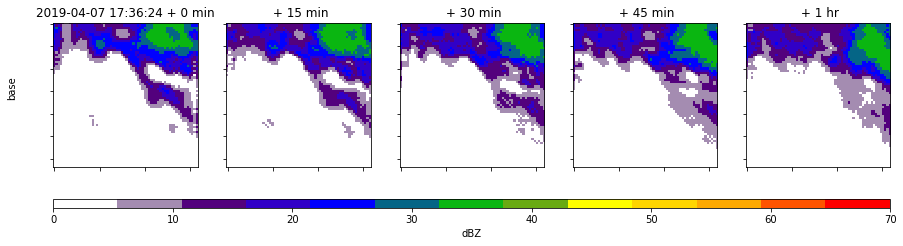

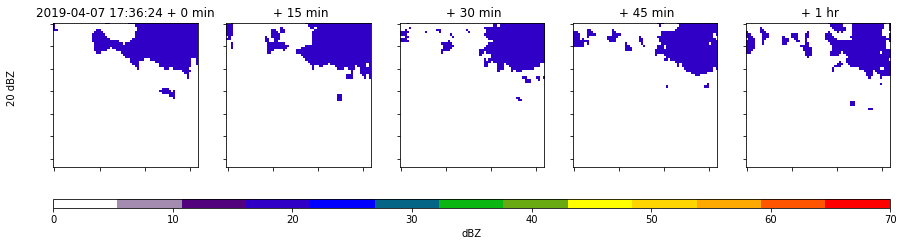

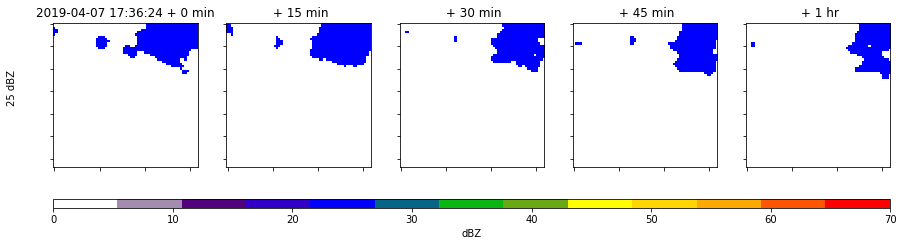

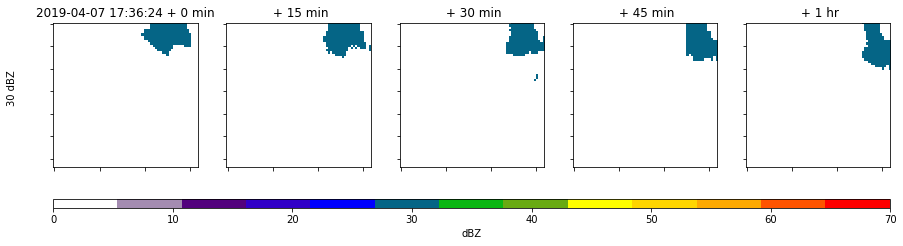

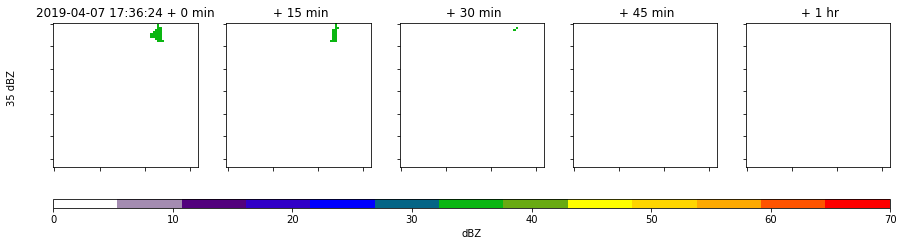

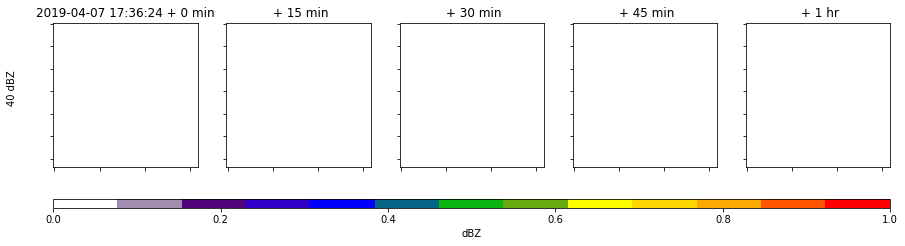

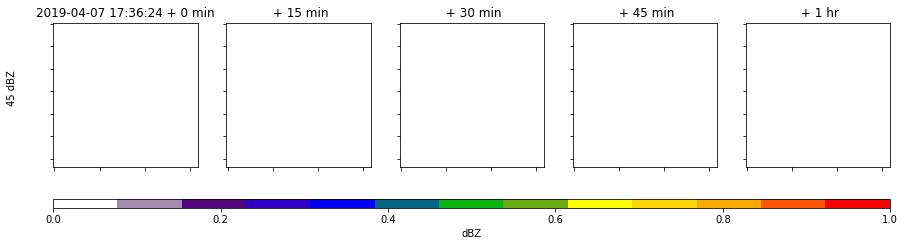

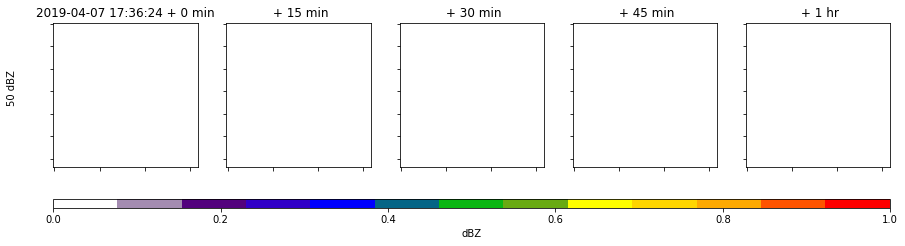

In [14]:
N = 0 # sample to plot
plot_my_composite(composite_base_file, None, N, plot_layers=True, plot_OBS=False, plot_map=False)

## Multi-model analysis


=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)
Samples used: 10
=> loaded checkpoint 'resGRU_16_16.pth' (trained for 300 epochs)
Samples used: 10
=> loaded checkpoint 'convGRU_16_16.pth' (trained for 300 epochs)
Samples used: 10
=> loaded checkpoint 'trajGRU_16_16.pth' (trained for 2 epochs)
Samples used: 10
=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)
=> loaded checkpoint 'resConv_16_16_bin20.pth' (trained for 24 epochs)
=> loaded checkpoint 'resConv_16_16_bin25.pth' (trained for 23 epochs)
=> loaded checkpoint 'resConv_16_16_bin30.pth' (trained for 11 epochs)
=> loaded checkpoint 'resConv_16_16_bin35.pth' (trained for 16 epochs)
Samples used: 10
Samples used: 10
Samples used: 10
Samples used: 10
Samples used: 10
Samples used: 10


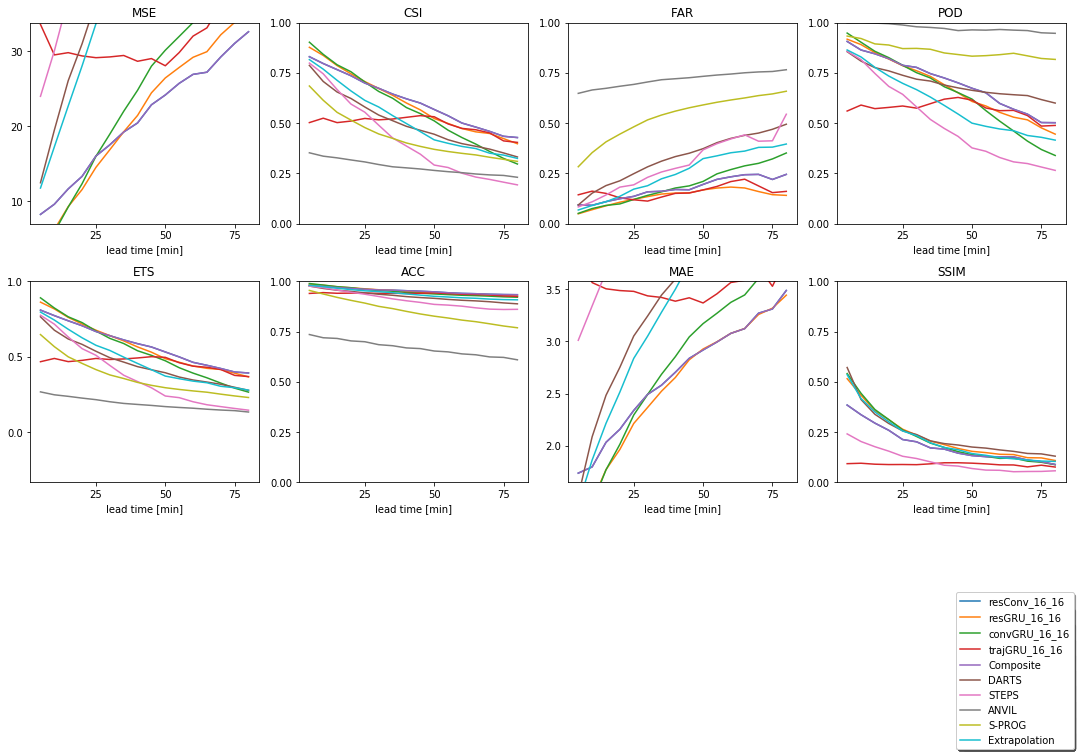

In [15]:
th = 20

files = ['resConv_16_16', 'resGRU_16_16', 'convGRU_16_16', 'trajGRU_16_16']
fig = my_models_metrics(files, th, None)

composite_base_file = 'resConv_16_16'
fig = my_composite_metrics(composite_base_file, th, fig)

file_darts = ['../data/checkpoints/DARTS_dallas.npy']
fig = others_models_metrics(file_darts, th, fig)

pysteps = ['STEPS', 'ANVIL', 'S-PROG', 'Extrapolation']
fig = others_models_metrics(pysteps, th, fig)

fig

=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)


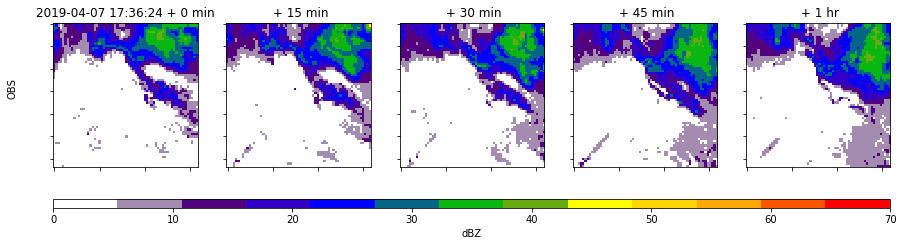

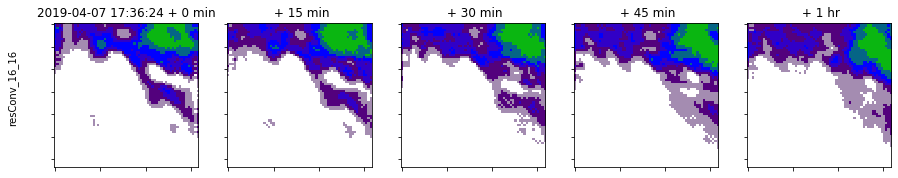

=> loaded checkpoint 'resGRU_16_16.pth' (trained for 300 epochs)


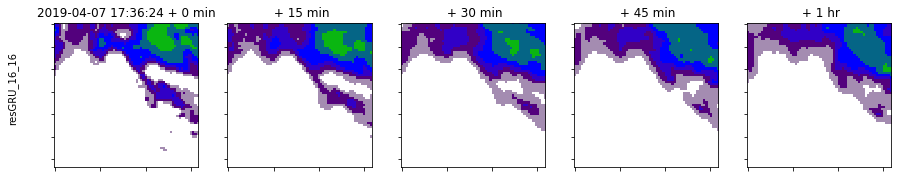

=> loaded checkpoint 'convGRU_16_16.pth' (trained for 300 epochs)


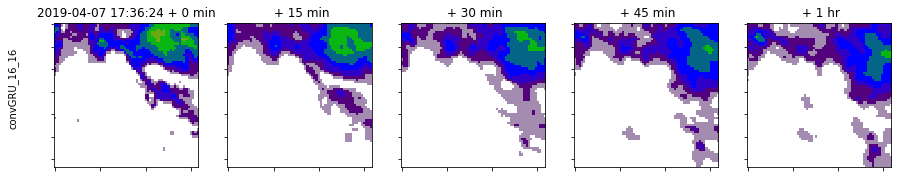

=> loaded checkpoint 'trajGRU_16_16.pth' (trained for 2 epochs)


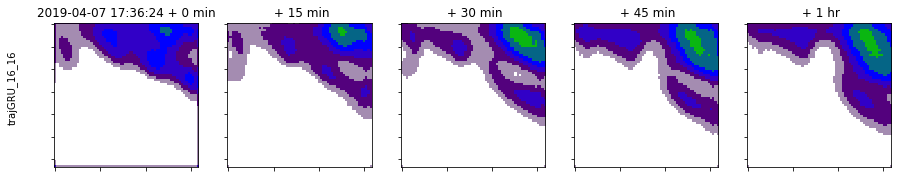

=> loaded checkpoint 'resConv_16_16.pth' (trained for 28 epochs)
=> loaded checkpoint 'resConv_16_16_bin20.pth' (trained for 24 epochs)
=> loaded checkpoint 'resConv_16_16_bin25.pth' (trained for 23 epochs)
=> loaded checkpoint 'resConv_16_16_bin30.pth' (trained for 11 epochs)
=> loaded checkpoint 'resConv_16_16_bin35.pth' (trained for 16 epochs)


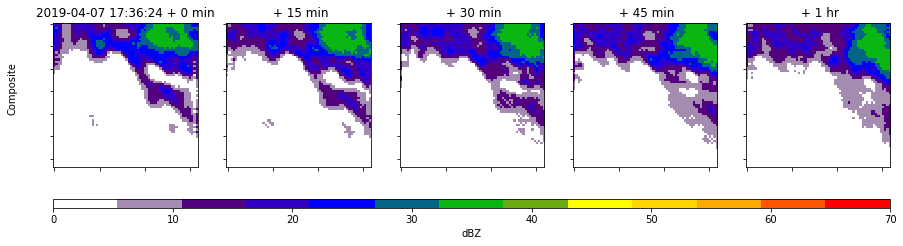

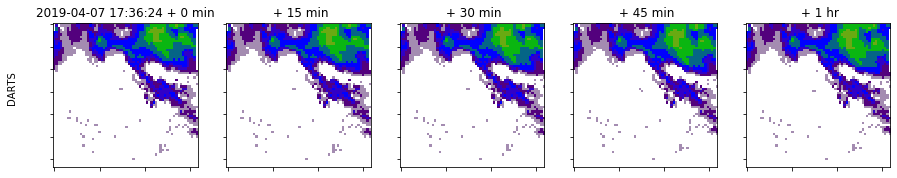

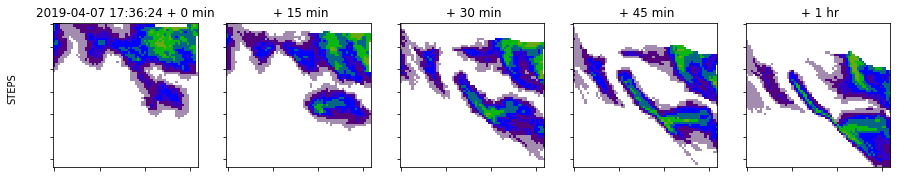

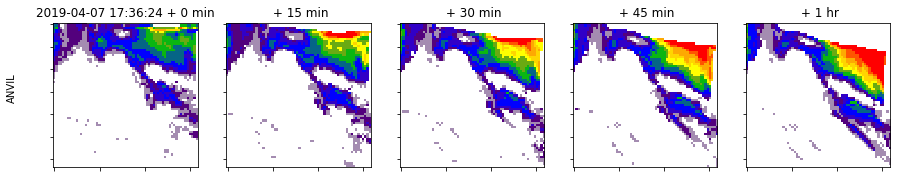

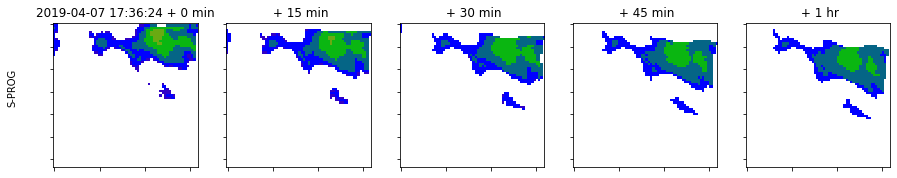

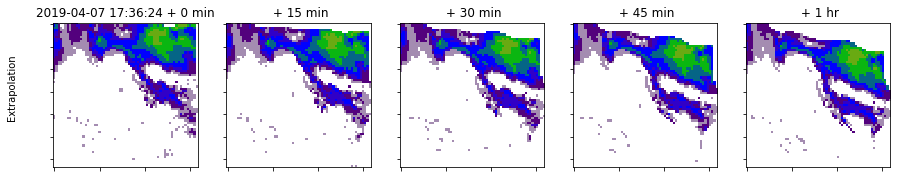

In [16]:
N = 0
plot_map = 0
plot_my_models(files, None, N, plot_OBS=1, plot_map=plot_map)
plot_my_composite(composite_base_file, None, N, plot_OBS=0, plot_map=plot_map)
plot_others_models(file_darts, None, N, plot_OBS=0, plot_map=plot_map)
plot_others_models(pysteps, th, N, plot_OBS=0, plot_map=plot_map)

## Average over thresholds

In [23]:
def getdata(figs, M):
    axes = [fig.axes for fig in figs]
    x = np.zeros((len(axes),8, M, 16))
    y = np.zeros((len(axes),8, M, 16))
    for i, th in enumerate(axes):
        for j, metric in enumerate(th):
            lines = metric.get_lines()
            for k, model in enumerate(lines):
                x_aux = model.get_xdata()
                x[i,j,k,:len(x_aux)] = x_aux
                y[i,j,k,:len(x_aux)] = model.get_ydata()
                
    #x[x==0]=np.NaN
                
    return x, y
                
import matplotlib as mpl

def metric_plots_avgTH(x, y, std_lines=False, get_legend=None):
 
    labels=['MSE', 'CSI', 'FAR', 'POD', 'ETS', 'ACC', 'MAE', 'SSIM']
    labels=[l+' (avg 20/25/30/35 dBZ)' if l in ['CSI', 'FAR', 'POD', 'ETS', 'ACC'] else l for l in labels]
    
    
    th_mean = np.nanmean(y,axis=0)
    th_var  = np.nanvar(y,axis=0)
    x = x.mean(0)
    n_metrics = x.shape[0]
    n_frames  = x.shape[2]
    rows = 2
    cols = int(np.ceil(n_metrics/rows))
    ranges = [None, (0,1), (0,1), (0,1), (-0.33,1), (0,1), None, (0,1)]
    colors=['#1f77b4','#ff7f0e','#2cac2c']
    #colors = ['blue','blue', 'red', 'red']
    #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['blue','blue', 'red', 'red']) 
    #mpl.rcParams['axes.prop_cycle'] = mpl.cycler(linestyle=['-','--','-','--']) 
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)+mpl.cycler(linestyle=['-', '-', '-'])
    line=['-','--','-','--']
    fig,axs = plt.subplots(nrows=rows, ncols=cols, figsize=(15,rows*3.5));
    axs = list(axs.reshape(-1))
    for m in range(n_metrics):
        axs[m].locator_params(nbins=4)
        axs[m].set_title(labels[m])
        axs[m].set_xlabel('lead time [min]')
        p = axs[m].plot(x[m].T, th_mean[m].T)
        axs[m].set_prop_cycle(None)
        if std_lines:
            axs[m].plot(x[m].T, th_mean[m].T+th_var[m].T,'--', alpha=0.7)
            axs[m].set_prop_cycle(None)
            axs[m].plot(x[m].T, th_mean[m].T-th_var[m].T,'--', alpha=0.7)
        #axs[m].set_ylim(ranges[m])
        axs[m].grid()
    for m in range(n_metrics,rows*cols):    
        axs[m].axis('off')
    if get_legend is not None:
        handles, labels = get_legend.get_axes()[n_metrics-1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right', fancybox=True, shadow=True)
    plt.tight_layout()
    plt.close()
    return fig

In [21]:
%%capture

composite_base_file = 'resConv_16_16'
file_darts = ['../data/checkpoints/DARTS_dallas.npy']

fig35 = my_composite_metrics(composite_base_file, 35)
fig30 = my_composite_metrics(composite_base_file, 30)
fig25 = my_composite_metrics(composite_base_file, 25)
fig20 = my_composite_metrics(composite_base_file, 20)

fig35 = others_models_metrics(file_darts, 35, fig35)
fig30 = others_models_metrics(file_darts, 30, fig30)
fig25 = others_models_metrics(file_darts, 25, fig25)
fig20 = others_models_metrics(file_darts, 20, fig20)

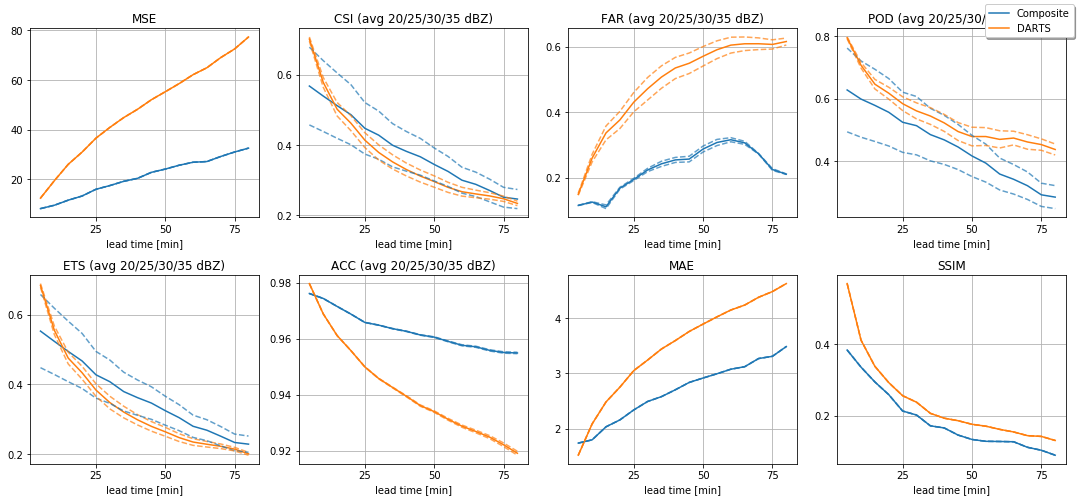

In [24]:
# set M to the number of predictions, in this case 2 for Composite and DARTS
x,y = getdata([fig20,fig25,fig30,fig35], M=2)
fig = metric_plots_avgTH(x, y, std_lines=True, get_legend=fig20);
fig